# Q1. I would like to ask if I am going to the right track 



## Ambulance Call-outs Model

$n_{A}$: sample size   
$x_{A}$: the total number who confirmed they did call an ambulance  
$p_{A}$: probability of a person call an ambulance   

$$x_{A} \sim Bin(n_{A},p_{A})$$

We assume $n_{A}=1000, p_A = 0.8$  
Suppose the prior of p is noninformative. 
$$p(p) \sim Beta(1,1)$$

**We suppose survey data exists: ($n_A, x_A$) known.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

In [2]:
# total survey participant
n_a = 1000
# the target we want to get 
p_a_set = 0.8

# assume we know this value
x_a = np.random.binomial(n_a,p_a_set, size=12)
print('given data x_a out of n_a=1000 for a year: \n',x_a)

given data x_a out of n_a=1000 for a year: 
 [785 797 816 808 805 801 826 821 804 768 790 799]


In [3]:
with pm.Model() as p_a_model:
    p_a = pm.Beta('p_a', alpha=1, beta=1, shape=(12,))
    x_a = pm.Binomial('x_a', n=n_a, p=p_a, observed=x_a)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1039.02draws/s]


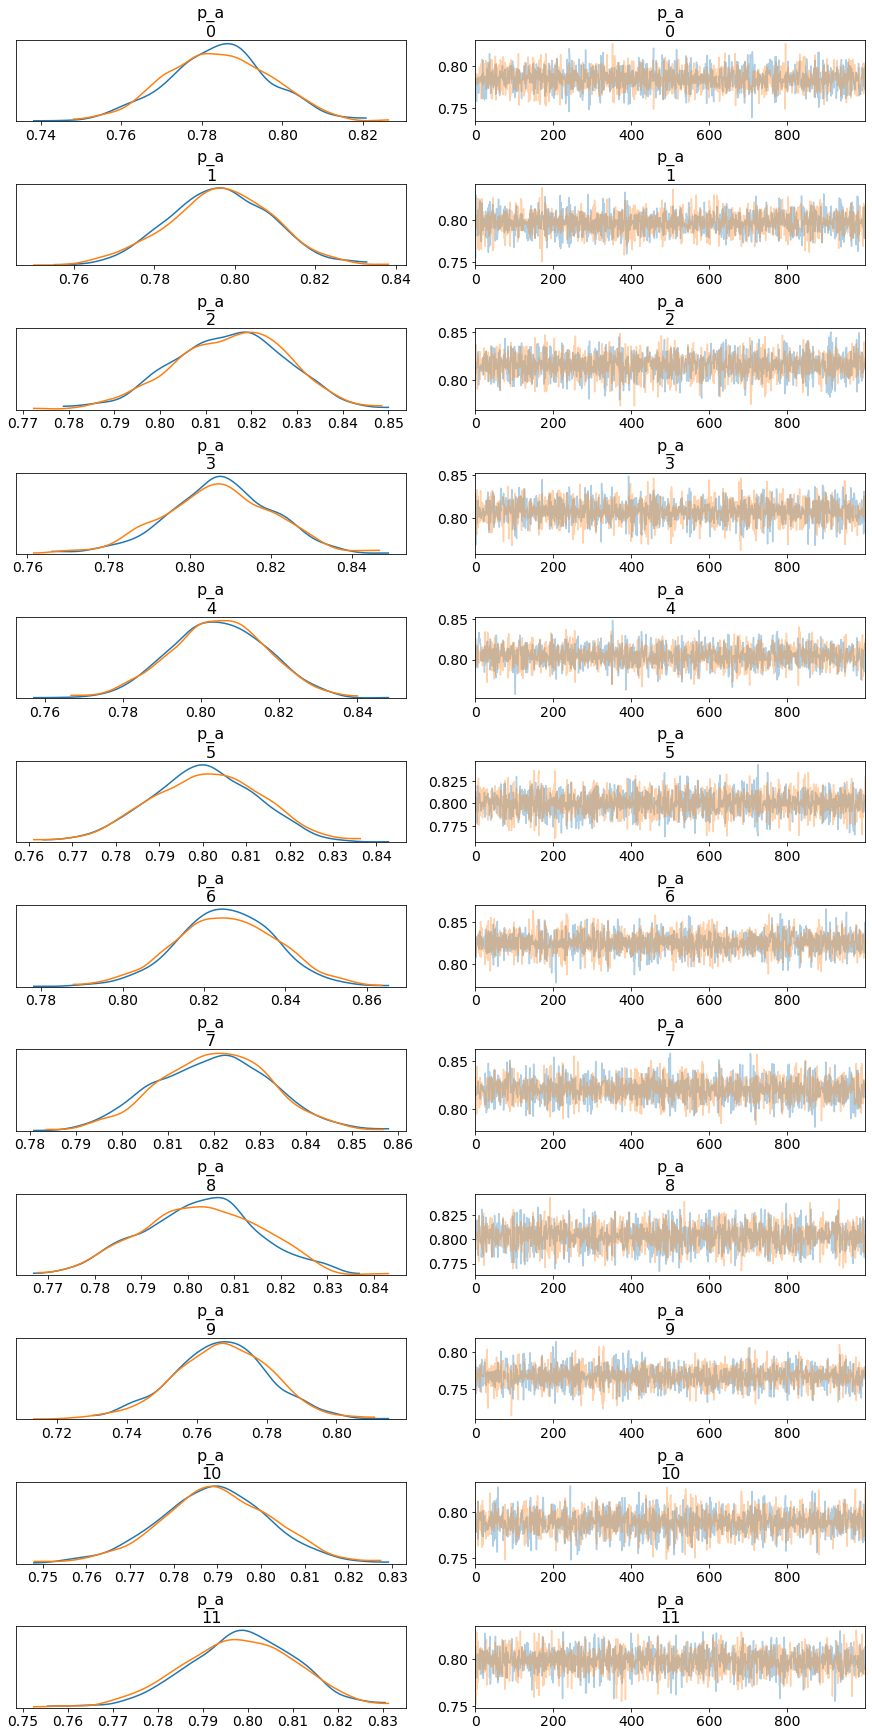

In [4]:
pm.traceplot(trace);

My first guess to make use of the samples of $p_A$ vector is to use MAP.  
**I am not sure if this is right**

In [5]:
map_estimate=pm.find_MAP(model = p_a_model)


/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2,391, ||grad|| = 1,046.3: 100%|██████████| 9/9 [00:00<00:00, 2168.72it/s]


In [6]:
p_a_map=map_estimate['p_a']

Now, since we have samples of $p_A$ from posterior distribution, we can plug in this values into the overdose model and obtain possible $O_t$ values **assuming we have $U_t$ values.**
Also, we have priors.


$$z_{t} \sim N(\mu, \sigma^{2})$$  
$$\lambda_{t}^{OD} = \exp(z_{t})$$  
$$O_{t} \sim Poi(\lambda_{t}^{OD}N)$$  
$$U_t \sim Bin(O_t, p_A)$$  
For simplicity we set N =10000 for now. Then $O_t$ values are influenced by prior $p(\mu, \sigma)$ and the likelihood of $U_t$ (combined with $p_A$ and additional variability from Binomial distribution). 


We need to generate reasonable $U_t$ values first. Note that $U_t$ comes from $\mu, \sigma$ following all the way through the overdose model.  

We set for our prior parameters: $\mu=-4, \sigma=1, N=10000$.

In [7]:
import random
random.seed(1)
N = 10000
z_t_set = np.random.normal(loc=-4, scale=1, size = 12)
o_t_set = np.random.poisson(lam=(np.exp(z_t_set)*N))
print('vector z_t: ', z_t_set)
print('vector o_t: ', o_t_set)

vector z_t:  [-2.39946871 -5.6644449  -4.66290271 -4.65152252 -4.70580081 -4.37408418
 -4.51652457 -5.59792216 -4.83260053 -3.74414889 -3.04818353 -3.43370391]
vector o_t:  [880  40  83 118  88 113  99  31  78 229 472 310]


We obtained $O_t$. **Since we assumed we only have $U_t$ values**, we obtain those from the given $O_t$ values.

In [8]:
u_t_set = np.random.binomial(n=o_t_set, p=p_a_set, size = 12)
print('vector u_t: ', u_t_set)

vector u_t:  [692  32  62  90  73  89  79  26  60 177 376 263]


The $U_t$ will be fit as a likelihood for the overdose model.

Priors are as follows:
$$p(\mu) \sim U(-10,0)$$
$$p(\sigma) \sim U(0,5)$$

In [9]:
with pm.Model() as overdose_model:
    #prior distributions
    mu = pm.Uniform('mu',-10, 0)
    sigma = pm.Uniform('sigma',0,5)
    
    #generate o_t
    z_t = pm.Normal('z_t', mu, sigma, shape=(12,))
    lam = pm.Deterministic('lambda', tt.exp(z_t))
    o_t = pm.Poisson('o_t', mu= N*lam, shape = (12,))
    
    #generate u_t
    u_t = pm.Binomial('u_t', n=o_t_set, p=p_a_map, observed=u_t_set)

    

In [10]:
with overdose_model:
    trace_od = pm.sample(1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [z_t, sigma, mu]
>Metropolis: [o_t]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 333.28draws/s]
The acceptance probability does not match the target. It is 0.9505629970363557, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9194905134759764, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


After reading the messages, I retried this. 

In [11]:
with overdose_model:
    trace_od = pm.sample(draws=5000, chains=2, tune=2000,target_accept=.85)

ValueError: Unused step method arguments: {'target_accept'}

**Since I do not understand the MCMC part yet, the error is not interpretable for me...**


In [ ]:
pm.traceplot(trace_od);